<a href="https://colab.research.google.com/github/daystram/ml-playground/blob/master/01_gym_cartpole/01a_gym_cartpole_neuroevolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01a Gym CartPole using Neuroevolution

*https://github.com/daystram/ml-playground*

----
Here we are going to start by attempting to work on one of OpenAI Gym's environment, `CartPole-v1`. This time we will be using a **reinforcement learning** approach.

Deep neural networks which uses genetic algorithm to mutate their weights will be used, i.e. **neuroevolution**. Hence, we will not be messing around with backpropagation to update them, unlike the ordinary neural network we have known. Unlike [NEAT](https://en.wikipedia.org/wiki/Neuroevolution_of_augmenting_topologies), we will not evolve the network topology.

The agent is created from scratch, its simple yet flexible enough that we can easily adjust the neural network layer topology, along with the activation functions on each of them.

## 0. Initialization

We will clone the git repo to load the setup script and required modules. The repo should also be added to Python's module-path for easier module imports.

In [0]:
!rm -r ml-playground > /dev/null 2>&1
!git clone https://github.com/daystram/ml-playground.git
!sh ml-playground/helper/setup.sh

Cloning into 'ml-playground'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 223 (delta 128), reused 112 (delta 48), pack-reused 0
Receiving objects: 100% (223/223), 429.79 KiB | 3.18 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (41.0.1)


In [0]:
import warnings; warnings.filterwarnings('ignore')
import sys; sys.path.append('/content/ml-playground')

## 1. Training the Model

### a. The Model
This is model that I created. The `Agent` is the individual neural network, which be evolved as a population in `Generation`. OpenAI 's Gym environment will be placed within a wrapper, `EnvWrapper`, which has methods for easy execution of these Agents in the environment. 

One thing to notice is that the Agents currently only allows fully connected layers. The output layers also only yield a single discrete value, as it is what `CartPole-v1`uses for its action space. To allow an array ouput, with continuous values, we can simply change the `act()` method to return the immediate result, without being passed through `np.argmax()`.

The model will heavily rely on the reward that the environment returns on every step. These rewards will act as the fitness when we do a selection on the population.

The Agent is also not very well optimized that it can take quite some time to train them.

In [0]:
from helper import srcdump

srcdump.dump('ml-playground/model/genetic_seq_neuralnet.py')

### b. Loading the Environment

Let's load the envorinment! We can see that the agent will return an observation for every step given the action. The observation will be a list of 4 elements, and th eaction will be a single discrete value of either 0 or 1. We will use this when we create our model.

In [0]:
import gym

env = gym.make("CartPole-v1")
env.reset()

print(env.observation_space)
print(env.action_space)

Box(4,)
Discrete(2)


### c. Creating and Training the Model

We'll wrap the loaded environment and create our model. The model is setup to have the properties:

- The model will be a deep neural network, with ReLU activation functions;
- There will be 50 of these in each generation, through the 100 generations of the training process;
- We allow a maximum of 7500 steps for the agent to run itself on the environment ( set this too low our agents will not be maximizing it's potentials to train for a full execution, leading to a plateau);
- Elitism is enabled (passing the top randomly selected fraction of the population to be passed directly without mutation to the next generation);
- Full-mutation rate of 0.3 (full-mutation is to let the weights on every nodes in the network to be deviated by a normal distribution with th egiven variance).

We can then begin the training! (it takes a really long time)

In [0]:
from model import genetic_seq_neuralnet as nn

wenv = nn.EnvWrapper(env, show=False)
wenv.reset()

shape = [(4,),           # input layer               
        (128, 'relu'),   # hidden layers
        (256, 'relu'), 
        (512, 'relu'), 
        (256, 'relu'), 
        (128, 'relu'), 
        (2, 'relu')]     # output layer
ga = nn.Generation(wenv, 50, 100, shape, step=7500, span=1, rate=0.30, elite=True, full_mutation=True, verbose=False)
agent, report = ga.run()

wenv.close()

------ GA: Starting
Generation  1:  max:153.0	avg:19.0	min:8.0
Generation  2:  max:291.0	avg:80.1	min:9.0
Generation  3:  max:432.0	avg:141.4	min:42.0
Generation  4:  max:500.0	avg:209.3	min:28.0
Generation  5:  max:387.0	avg:202.4	min:65.0
Generation  6:  max:500.0	avg:253.4	min:98.0
Generation  7:  max:500.0	avg:225.9	min:68.0
Generation  8:  max:500.0	avg:267.1	min:61.0
Generation  9:  max:410.0	avg:229.7	min:70.0
Generation 10:  max:488.0	avg:214.7	min:22.0
Generation 11:  max:386.0	avg:217.4	min:33.0
Generation 12:  max:500.0	avg:223.1	min:26.0
Generation 13:  max:500.0	avg:234.7	min:39.0
Generation 14:  max:500.0	avg:258.2	min:52.0
Generation 15:  max:500.0	avg:257.2	min:13.0
Generation 16:  max:500.0	avg:251.1	min:92.0
Generation 17:  max:500.0	avg:217.7	min:115.0
Generation 18:  max:500.0	avg:207.9	min:63.0
Generation 19:  max:500.0	avg:241.9	min:58.0
Generation 20:  max:500.0	avg:227.7	min:50.0
Generation 21:  max:476.0	avg:219.3	min:73.0
Generation 22:  max:500.0	avg:231.0	mi

## 2. Evaluation

It is quite a surprise to see such an improvement of the model through the generations. We can see a steady growth of the generation's average score. The seemingly unimproving minimum fitness in each generation are those agents whose weights have been mutated and does suit the goal, they have a lower chance of being selected to be passed to next generations.

(if you haven't noticed, 500 is the max fitness that the environment yields before stopping)

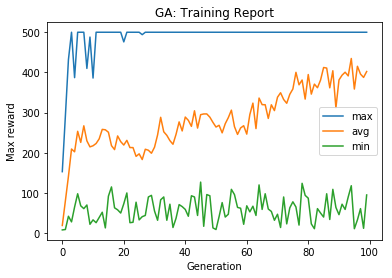

------ GA: Overall Best Reward 500.0


In [0]:
import matplotlib.pyplot as plt
diag = plt.plot(report)
plt.legend(diag, ('max', 'avg', 'min'))
plt.title('GA: Training Report')
plt.ylabel('Max reward')
plt.xlabel('Generation')
plt.show()

print("------ GA: Overall Best Reward {:.1f}".format(agent.reward))

Here we will attempt to test the agent by running it on the environment and see how it does.

In [0]:
from helper import nbdisplay as disp

!rm -r video
renv = disp.wrap_env(gym.make("CartPole-v1"))
wrenv = nn.EnvWrapper(renv, show=True)

agent.reset()
wrenv.execute(agent, -1)  
wrenv.close()
 
disp.show_video()
print("------ RUN: Reward {:.1f}".format(agent.reward))
print("Video can be viewed in Google Colab, use the link on top of the page to open")

------ RUN: Reward 500.0
Video can be viewed in Google Colab, use the link on top of the page to open


Very well, let's save that agent.

In [0]:
nn.Agent.save(agent)